In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from scipy import spatial

color_list =["#3eb991","#e9a820","#e01563","#edb196","#6ecadc","#1f94ac","#ae9a6a","#ccb8a6","#343a44"]

In [48]:
# defining function for diffusion in 3D over time
def single_step(X, Y, theta, delta_T):
    
    # defining variables
    v = 1 * pow(10, -6); 
    omega = 0; 
    D_r = 0.05; 
    D_t = 0.1 * pow(10, -12); 

    delta_X, delta_Y = 0, 0; 
    delta_theta = 0; 

    # randomly sampling in a uniform distribution from 0 to 1 to get an angle
    W_theta = (math.pi / 2) * np.random.uniform(-1, 1); 

    # randomly sampling noise in Gaussian distrib. with mean 0 and variance 1
    W_X = np.random.normal(0, 1); 
    W_Y = np.random.normal(0, 1); 

    # solving change in position for each dimension
    delta_X = v * np.cos(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_X; 
    delta_Y = v * np.sin(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_Y; 

    # solving change in each angle
    delta_theta = omega * delta_T + np.sqrt(2 * D_r * delta_T) * W_theta; 

    # using a temporary variable to track position and angle
    X += delta_X; 
    Y += delta_Y; 
    theta += delta_theta; 
    
    temp_postition = []; 
    temp_postition = np.array([X, Y, theta]); 

    return temp_postition; # returning coordinates and diffusion coefficient (for comparison later)

In [49]:
class makeSwimmer: # defines swimmer class
  def __init__(self, x, y, theta, start_time, parent): # one can enter with 0, 0, 0 start or other
    self.start_time = start_time; 
    self.position = np.array([[x, y, theta]]); 
    self.parent = parent; # the index of the swimmer you diverged from (in the list)
    self.density = 100000; # finding the density of nearby swimmers
    self.swimming = True; # this will define if the swimmer is swimming or still, True = swim, False = still
    self.stall_time = 0; 
    # notes: 
    # make divide time, subtract from current time, use this to induce stalling --- built in cool down
    # need second stalling metric, for when local density is high enough
    # will also need some metric of ensuring movement for some time after movement resumes
    #
    #

In [50]:
def find_probability(density, delta_T):
    sigma = 2; 
    mean = 5; 
    max = 0.5 * (1 / pow(2 * math.pi, 0.5)) * np.exp(- 0.5 * pow(((mean - mean) / sigma), 2)); # used to normalize
    probability = (1 / max) * 0.5 * (1 / pow(2 * math.pi, 0.5)) * np.exp(- 0.5 * pow(((density - mean) / sigma), 2)); # normalized to 1

    bool_temp = False; 
    if probability > np.random.uniform(0, 1): 
        bool_temp = True; 
      
    return bool_temp; 

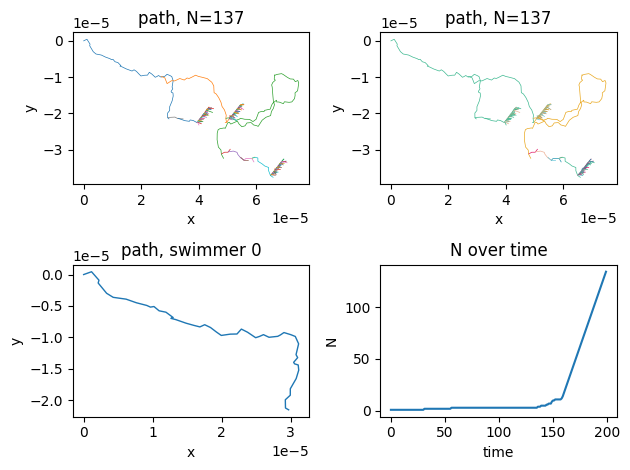

In [51]:
total_time = 200; # in seconds? 
delta_T = 1; 
indexed_time = int(total_time / delta_T); # used to index through time list 
swimmer_Radius = 1 * pow(10, -7); # this is the swimmer size (too small?), so that when they divide their centers will be offset by this 

swimmerList = []; # a list of swimmers
for i in range(0, 1, 1): # initializes a list of 10 swimmers 
    swimmerList.append(makeSwimmer(0, 0, 0, 0, 0)); # set starting point at 0, 0

population_size = []; 
temp_coords_list = np.array([[0, 0]]); 
for time in range(0, indexed_time, 1): 
    population_size.append(len(swimmerList)); 

    # this is used to find the nearest swimmer 
    # let us instead try to convert this module to density of nearby swimmers
    temp_coords_list = np.delete(temp_coords_list, 0, 0); # removes first element of array, I think

    for i in range(0, len(swimmerList), 1):
        time_effective = time - swimmerList[i].start_time; # to make using the start time easier
        compare_coord = [[swimmerList[i].position[time_effective, 0], swimmerList[i].position[time_effective, 1]]]; 
        distances = spatial.distance.cdist(temp_coords_list, compare_coord).flatten(); # flatten added to reduce to 1D array
        distances = distances[distances != 0]; # used to remove / extract non-zero numbers (i.e., self)

        # let us cleverly modify this to say within 1 micron 
        if swimmerList[i].swimming: # boolean value for if the swimmer is swimming or still
            local_density = 0; 
            for distance in distances:
                if distance < 0.001: # 1 mm
                    local_density += 1; # increases for swimmers in this range
                    # note that if not satisfied, local density = 0, which is correct
            swimmerList[i].density = local_density; # stores local density 
    
    temp_coords_list = np.array([[0, 0]]); 
    
    for i in range(0, len(swimmerList), 1):

        time_effective = time - swimmerList[i].start_time; # to make using the start time easier
        arr = swimmerList[i].position[time_effective]; # to store the previous position 

        if swimmerList[i].swimming:
            temp_coords = single_step(arr[0], arr[1], arr[2], delta_T); 
            swimmerList[i].position = np.vstack((swimmerList[i].position, temp_coords)); 
            temp_coords_list = np.vstack((temp_coords_list, [temp_coords[0], temp_coords[1]])); 
        elif swimmerList[i].stall_time > 0:
            swimmerList[i].stall_time = swimmerList[i].stall_time - delta_T; 
            swimmerList[i].position = np.vstack((swimmerList[i].position, [arr[0], arr[1], arr[2]])); 
        else: 
            swimmerList[i].swimming = True; 
            swimmerList[i].stall_time = 0; 
            swimmerList[i].position = np.vstack((swimmerList[i].position, [arr[0], arr[1], arr[2]])); 

        # determining probability, then using a random number generator to define division
        bool_divide = find_probability(swimmerList[i].density, delta_T); 

        if bool_divide and swimmerList[i].swimming: # currently causing stoachstic cell division
            swimmerList[i].swimming = False; # causes swimmer to stop 
            swimmerList[i].stall_time = 100; # sets duration of stopping
            offset = np.random.normal(0, swimmer_Radius); 
            x_after_divide = arr[0] + offset; # causes next swimmer to start around body length away
            y_after_divide = arr[1] + offset; 
            swimmerList.append(makeSwimmer(x_after_divide, y_after_divide, 0, time + 1, i)); # set starting point at 0, 0
            temp_coords_list = np.vstack((temp_coords_list, [x_after_divide, y_after_divide])); 

# 2d graphing definitions
plt.subplot(2, 2, 1); # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5); 
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently 

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
# plt.gca().set_aspect(0.75)

plt.subplot(2, 2, 2); # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5, color = color_list[swimmerList[i % len(color_list)].parent]); 
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently 

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
# plt.gca().set_aspect(0.75)

plt.subplot(2, 2, 3); # putting plots on the same image, this at row 1, col 1, index 1
plt.plot(swimmerList[0].position[:,0], swimmerList[0].position[:,1], linewidth=1); 

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, swimmer 0")
plt.tight_layout()
# plt.gca().set_aspect(0.75)

plt.subplot(2, 2, 4); # putting plots on the same image, this at row 1, col 1, index 1
plt.plot(np.arange(0, total_time, delta_T), population_size); 

plt.xlabel('time')
plt.ylabel('N')
plt.title("N over time")
plt.tight_layout()
# plt.gca().set_aspect('equal')